In [26]:
## Tutorial on Gaussian Processes

# based on the following tutorial

import numpy as np
import matplotlib.pylab as plt

# we define our covariance function as a squared exponential: this is the kernel for a GP
def exponential_cov(x, y, params):
    '''
    Covariance between two points decreases exponentially as the distance between them increases
    '''
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

# implement the multivariate gaussian conditional distribtion
def conditional(x_new, x, y, params):
    """
    Args:
        x_new (_type_): input point where we want to predict
        x (_type_): already observed data points input
        y (_type_): observed data points response
        params (_type_): parameters of the covariance function, here the amplitude and the length scale
    """
    B = exponential_cov(x_new, x, params)       # sigma_xy
    C = exponential_cov(x, x, params)           # sigma_y
    A = exponential_cov(x_new, x_new, params)   # sigma_x
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

# -> y is not directly used to calculate the covariance: the key idea is that we assume a prior distribution over functions
# where the covariance function encodes our assumptions how different function values relate to each other

def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

<ErrorbarContainer object of 3 artists>

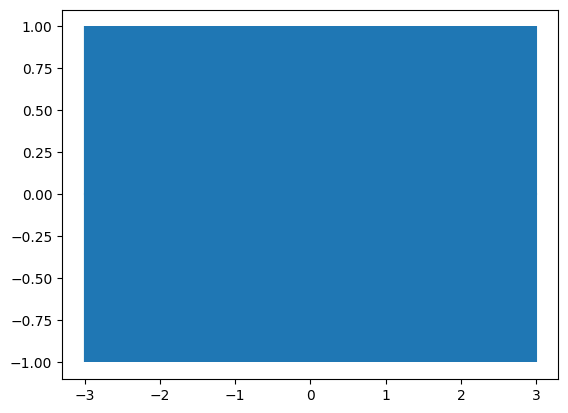

In [27]:
hyperparam = [1, 10]
sigma_0 = exponential_cov(0, 0, hyperparam)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma_0, capsize=0)

In [28]:
# now we can sample an arbitrary starting point from an uncoditional gaussian
x = [1.]
y = [np.random.normal(scale=sigma_0)]
print(y)

[0.5404504264722195]


In [29]:
# we update our sigma based on the sampled point
sigma_1 = exponential_cov(x, x, hyperparam)

x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, hyperparam, sigma_1, y) for i in x_pred]

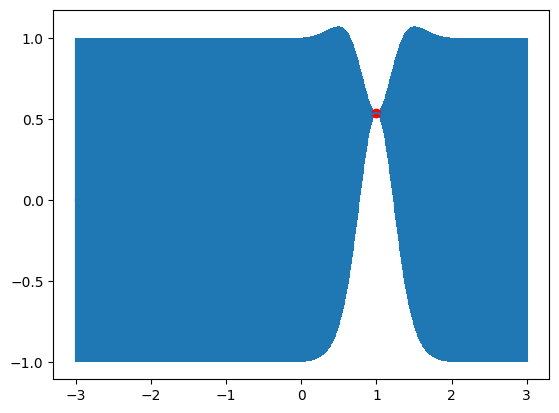

In [30]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

In [31]:
m, s = conditional([-0.7], x, y, hyperparam)
y2 = np.random.normal(m, s)
print(y)

[0.5404504264722195]


In [32]:
x.append(-0.7)
y.append(y2)
sigma_2 = exponential_cov(x, x, hyperparam)
predictions = [predict(i, x, exponential_cov, hyperparam, sigma_2, y) for i in x_pred]

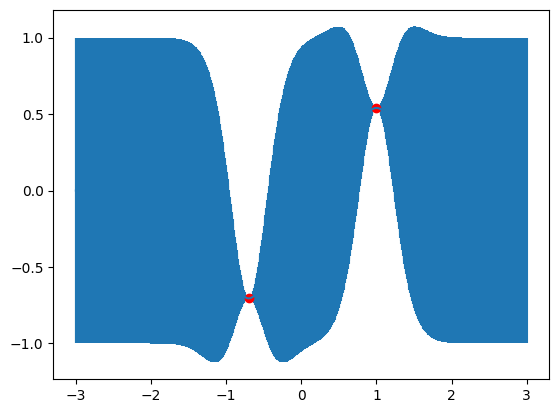

In [33]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

In [34]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, hyperparam)
y_more = np.random.multivariate_normal(mu, s)
print(y_more)

[ 0.60515821 -1.0239867   0.10808422  0.27482372 -0.04047653]


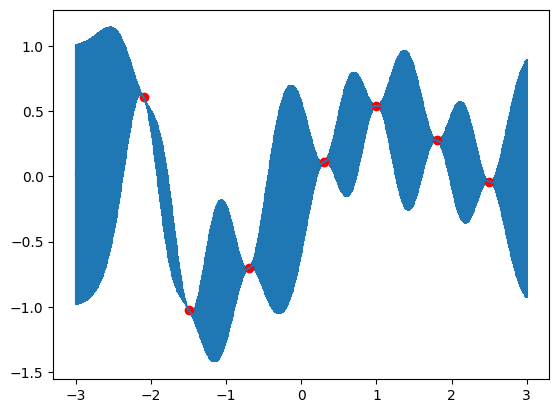

In [35]:
x += x_more
y += y_more.tolist()
sigma_new = exponential_cov(x, x, hyperparam)
predictions = [predict(i, x, exponential_cov, hyperparam, sigma_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

We sample a point from a gaussian distribution, then update our prior with that point and sample a from the updated prior and update our prior again. That way we sample a random function from our Gaussian Process.

## Fitting a Gaussian Process with scikit learn

Here the GaussianProcessRegressor does not allow for the specification of a mean function.

If the posterior is assumed to be non-normal, a Laplace approximation is used to obtain a solution, rather than maximizing the marginal likelihood.

Info: latent variables are variables that are not directly observed but are assumed to exist based on the observed data

In [36]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

In [37]:
# in sklearn we can simply combine kernel by adding them up
kernel = ConstantKernel()+ Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1) # amplitude factor, matern and observation noise

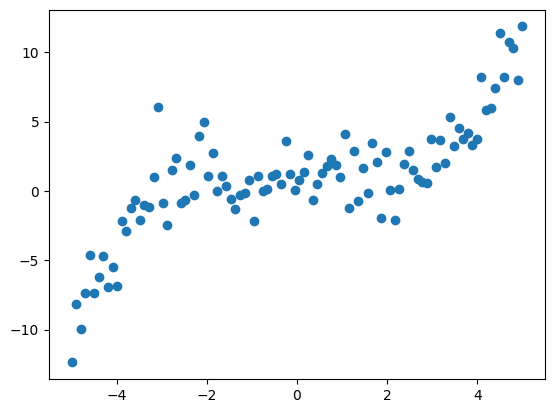

In [56]:
# sample some data to fit 

# Define a complex function with sinusoidal components and polynomial terms
def complex_function(x):
    return (0.5 * np.sin(1.5 * x) + 0.3 * np.cos(2.0 * x) + 
            0.2 * np.sin(3.0 * x) + 0.1 * x**3 - 0.5 * x + 1)

# Generate x values
x = np.linspace(-5, 5, 100)

# Sample the function and add some random noise
y = complex_function(x) + np.random.normal(scale=1.5, size=x.shape)

# Plot the sampled data
plt.scatter(x, y)
plt.show()

X = x.reshape(-1, 1)

In [60]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

GaussianProcessRegressor(kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1))

In [61]:
x_pred = np.linspace(-6, 6).reshape(-1, 1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

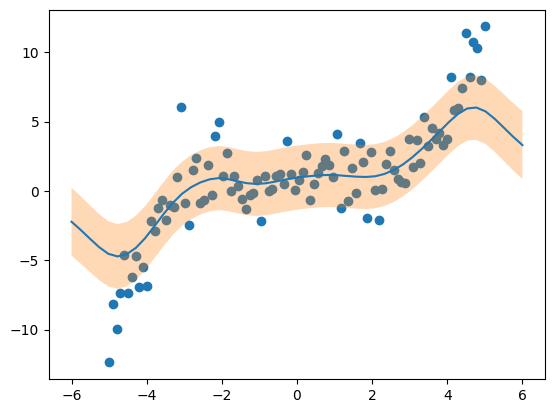

In [70]:
plt.scatter(x, y)
plt.plot(x_pred, y_pred)
plt.fill_between(x_pred.reshape(-1), y_pred+sigma, y_pred - sigma, alpha = .3)